# 第四章　暖冷房設備 / Chapter 4 Heating and cooling equipment

## 第七節　FF暖房機 / Section 7 Hot Water Heating

In [1]:
import numpy as np

## 試算例

### 初期条件

In [2]:
def get_default_hot_water_heating():
    
    house_base = {"region": 6, "A_A": 120.08, "A_MR": 29.81, "A_OR": 51.34}
    house_ENV = {"A_env": 307.51, "U_A": 0.87, "eta_A_H": 4.3, "eta_A_C": 2.8, 'method': '当該住宅の外皮面積の合計を用いて評価する'}
    H_MR = {'type': '温水暖房用パネルラジエーター'}
    H_OR = {'type': '温水暖房用パネルラジエーター'}
    H_HS = {'type': 'ガス従来型温水暖房機', 'e_rtd_hs': 0.81, 'pipe_insulation': False, 'underfloor_pipe_insulation': False}
    
    return house_base, house_ENV, H_MR, H_OR, H_HS

### 計算

In [3]:
def calc_results(house_base, house_ENV, H_MR, H_OR, H_HS):

    from pyhees.section4_1 import get_virtual_heating_devices, calc_E_UT_H_d_t__modeMROR, get_alpha_UT_H_MR, get_alpha_UT_H_OR, calc_Q_UT_H_MR_d_t, calc_Q_UT_H_OR_d_t
    from pyhees.section4_1_a import calc_heating_mode
    from pyhees.section2_1_b import get_f_prim
    from pyhees.section2_2 import calc_heating_load, calc_cooling_load
    from pyhees.section3_1 import get_Q
    from pyhees.section3_2 import calc_insulation_performance
    from pyhees.section4_7 import calc_E_E_H_d_t, calc_E_G_H_d_t, calc_E_K_H_d_t, calc_E_M_H_d_t


    sol_region = None
    NV_MR = 0
    NV_OR = 0
    r_A_ufvnt = None
    underfloor_insulation = False
    TS = None
    HEX = None
    SHC = None
    HW = None

    mode_H = '居室のみを暖房する方式でかつ主たる居室とその他の居室ともに温水暖房を設置する場合に該当しない場合'
    mode_C = '居室のみを冷房する方式'

    house_ENV['A_A'] = house_base['A_A']



    # ---- 外皮の計算 ----

    # 外皮の断熱性能の計算
    if house_ENV is not None:
        U_A, _, _, _, Q_dash, eta_H, eta_C, _ = calc_insulation_performance(**house_ENV)
        # 熱損失係数
        Q = get_Q(Q_dash)
        A_env = house_ENV.get('A_env')
    else:
        Q = None
        eta_H, eta_C = None, None
        A_env = None

    
    # 実質的な暖房機器の仕様を取得
    spec_MR, spec_OR = get_virtual_heating_devices(house_base['region'], H_MR, H_OR)

    # 暖房方式及び運転方法の区分
    mode_MR, mode_OR = calc_heating_mode(region=house_base['region'], H_MR=spec_MR, H_OR=spec_OR)

    # 暖房負荷の取得
    L_T_H_d_t_i, _ = calc_heating_load(
        house_base['region'], sol_region, house_base['A_A'], house_base['A_MR'], house_base['A_OR'],
        Q, eta_H, eta_C, NV_MR, NV_OR, TS, r_A_ufvnt, HEX, underfloor_insulation, mode_H, mode_C,
        spec_MR, spec_OR, mode_MR, mode_OR, SHC)

    # 冷房負荷の取得
    L_CS_d_t, L_CL_d_t = \
    calc_cooling_load(house_base['region'], house_base['A_A'], house_base['A_MR'], house_base['A_OR'], Q, eta_H, eta_C,
                        NV_MR, NV_OR, r_A_ufvnt, underfloor_insulation, mode_C, mode_H, mode_MR, mode_OR, TS, HEX)



    # 電気消費量
    E_E_H_d_t = calc_E_E_H_d_t(H_HS, H_MR, H_OR, house_base['A_A'], house_base['A_MR'], house_base['A_OR'], house_base['region'], mode_MR, mode_OR, L_T_H_rad=L_T_H_d_t_i, L_CS_x_t=L_CS_d_t, L_CL_x_t=L_CL_d_t, CG=None)
    
    # ガス消費量
    E_G_H_d_t = calc_E_G_H_d_t(H_HS, H_MR, H_OR, house_base['A_A'], house_base['A_MR'], house_base['A_OR'], house_base['region'], mode_MR, mode_OR, L_T_H_rad=L_T_H_d_t_i, HW=HW, CG=None)

    # 灯油
    E_K_H_d_t = calc_E_K_H_d_t(H_HS, H_MR, H_OR, house_base['A_A'], house_base['A_MR'], house_base['A_OR'], house_base['region'], mode_MR, mode_OR, L_T_H_rad=L_T_H_d_t_i, HW=HW, CG=None)

    # その他の燃料
    E_M_H_d_t = calc_E_M_H_d_t(H_HS)

    # 未処理暖房負荷の設計一次エネルギー消費量相当値
    # 住戸全体の未処理負荷を計算
    E_UT_H_d_t = calc_E_UT_H_d_t__modeMROR(house_base['region'], house_base['A_A'], house_base['A_MR'], house_base['A_OR'], \
                                            spec_MR, spec_OR, H_HS, mode_MR, mode_OR, HW=None, CG=None, L_T_H_d_t=L_T_H_d_t_i, L_CS_d_t=L_CS_d_t, L_CL_d_t=L_CL_d_t)

    # 温水暖房以外の未処理負荷を計算
    has_MR_hotwaterheating = spec_MR['type'] in ['温水暖房用パネルラジエーター', '温水暖房用床暖房', '温水暖房用ファンコンベクター', '温水床暖房（併用運転に対応）']
    has_OR_hotwaterheating = spec_OR['type'] in ['温水暖房用パネルラジエーター', '温水暖房用床暖房', '温水暖房用ファンコンベクター', '温水床暖房（併用運転に対応）']

    if has_MR_hotwaterheating == True or has_OR_hotwaterheating == True:
        if has_MR_hotwaterheating == True and has_OR_hotwaterheating == False: # その他居室が控除対象
            alpha_UT_H_OR = get_alpha_UT_H_OR(house_base['region'], mode_OR)
            Q_UT_H_OR_d_t = calc_Q_UT_H_OR_d_t(house_base['region'], house_base['A_A'], house_base['A_MR'], house_base['A_OR'], spec_MR, spec_OR, H_HS, mode_MR, mode_OR, HW, CG=None, L_T_H_d_t=L_T_H_d_t_i)
            reduce_E_UT_H_d_t = alpha_UT_H_OR * Q_UT_H_OR_d_t
        elif has_MR_hotwaterheating == False and has_OR_hotwaterheating == True: # 主居室が控除対象
            alpha_UT_H_MR = get_alpha_UT_H_MR(house_base['region'], mode_MR)
            Q_UT_H_MR_d_t = calc_Q_UT_H_MR_d_t(house_base['region'], house_base['A_A'], house_base['A_MR'], house_base['A_OR'], spec_MR, spec_OR, H_HS, mode_MR, mode_OR, HW, CG=None, L_T_H_d_t=L_T_H_d_t_i)
            reduce_E_UT_H_d_t = alpha_UT_H_MR * Q_UT_H_MR_d_t
        else:
            reduce_E_UT_H_d_t = 0
    else:
        reduce_E_UT_H_d_t = 0

    # 温水暖房分の未処理暖房負荷の設計一次エネルギー消費量相当値
    E_UT_H_d_t = E_UT_H_d_t - reduce_E_UT_H_d_t

    
    # 電気の一次エネルギー換算係数
    f_prim = get_f_prim()

    E_H_d_t = E_E_H_d_t * f_prim / 1000 + E_G_H_d_t + E_K_H_d_t + E_M_H_d_t + E_UT_H_d_t
    print(f'E_H={np.sum(E_H_d_t)}MJ/a')
    
    return E_H_d_t

In [4]:
def get_each_graph(_E_H_d_t):

    import matplotlib.pyplot as plt

    _E_H_d = np.sum(_E_H_d_t.reshape(365,24), axis = 1)

    fig = plt.figure(figsize = (20,7))

    grh_day = fig.add_subplot(211)
    grh_day.set_ylabel('MJ/d')
    grh_day.set_xlabel('day')
    grh_day.plot(_E_H_d, label = "E_H")
    grh_day.legend()

    grh_date = fig.add_subplot(212)
    grh_date.set_ylabel('MJ/h')
    grh_date.set_xlabel('hour')
    grh_date.plot(_E_H_d_t.reshape(365,24)[334], label = "E_H:12/1")
    grh_date.plot(_E_H_d_t.reshape(365,24)[59], label = "E_H:3/1")
    grh_date.legend()

    plt.show()


### 計算条件1

- 初期条件での計算

In [5]:
house_base, house_ENV, H_MR, H_OR, H_HS = get_default_hot_water_heating()

E_H_d_t_1 = calc_results(house_base, house_ENV, H_MR, H_OR, H_HS)

ガス従来型温水暖房機 E_G_hs = 39327.0323116396 [MJ] (L_T_H_rad = 26169.07775262852 [MJ])
ガス従来型温水暖房機 E_E_hs = 261.4815269263663 [kwh]
温水暖房用パネルラジエーター E_E_rad_d_t_1 = 0.0 [KWh] (L_T_H_rad_d_t_1 = 13369.716326035541 [MJ])
温水暖房用パネルラジエーター E_E_rad_d_t_3 = 0.0 [KWh] (L_T_H_rad_d_t_3 = 4975.1037042428225 [MJ])
温水暖房用パネルラジエーター E_E_rad_d_t_4 = 0.0 [KWh] (L_T_H_rad_d_t_4 = 3457.1898249005208 [MJ])
温水暖房用パネルラジエーター E_E_rad_d_t_5 = 0.0 [KWh] (L_T_H_rad_d_t_5 = 4367.067897449638 [MJ])
ガス従来型温水暖房機 E_G_hs = 39327.0323116396 [MJ] (L_T_H_rad = 26169.07775262852 [MJ])
ガス従来型温水暖房機 E_K_hs = 0.0 [MJ] (L_T_H_rad = 26169.07775262852 [MJ])
温水暖房用パネルラジエーター Q_UT_H_d_t_1 = 0.4193211985240808 [MJ]
温水暖房用パネルラジエーター Q_UT_H_d_t_2 = 0.0 [MJ]
温水暖房用パネルラジエーター Q_UT_H_d_t_3 = 0.0 [MJ]
温水暖房用パネルラジエーター Q_UT_H_d_t_4 = 0.0 [MJ]
温水暖房用パネルラジエーター Q_UT_H_d_t_5 = 0.3157451815366752 [MJ]
Q_UT_hs = 50.315705897968186 [MJ]
E_H=41880.24606865763MJ/a


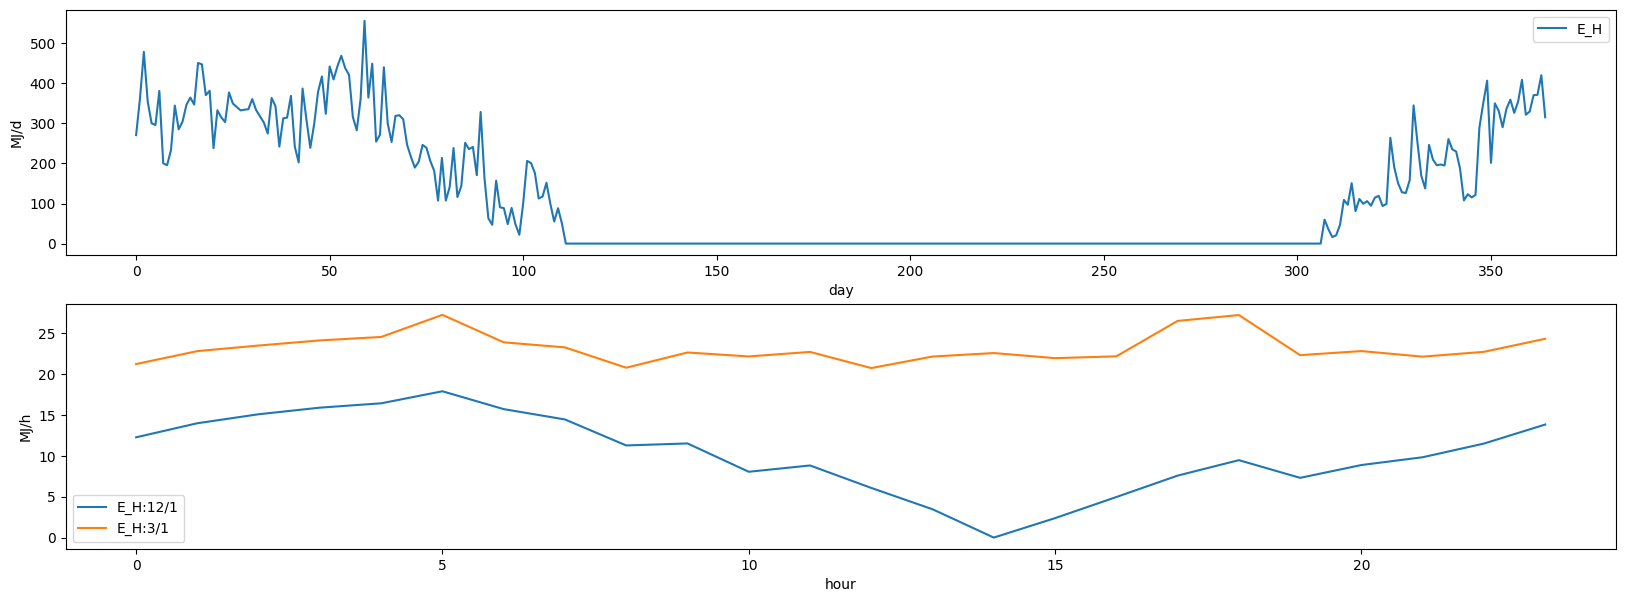

In [6]:
get_each_graph(E_H_d_t_1)

### 計算条件2

- 主たる居室とその他の居室の暖房設備をファンコンベクターに変更

In [7]:
house_base, house_ENV, H_MR, H_OR, H_HS = get_default_hot_water_heating()
H_MR = {'type': '温水暖房用ファンコンベクター'}
H_OR = {'type': '温水暖房用ファンコンベクター'}

E_H_d_t_2 = calc_results(house_base, house_ENV, H_MR, H_OR, H_HS)

ガス従来型温水暖房機 E_G_hs = 21583.816680487995 [MJ] (L_T_H_rad = 15098.284160204563 [MJ])
ガス従来型温水暖房機 E_E_hs = 141.42951390040668 [kwh]
温水暖房用ファンコンベクター E_E_rad_d_t_1 = 25.497507723201373 [KWh] (L_T_H_rad_d_t_1 = 11859.427924442796 [MJ])
温水暖房用ファンコンベクター E_E_rad_d_t_3 = 0.0 [KWh] (L_T_H_rad_d_t_3 = 0.0 [MJ])
温水暖房用ファンコンベクター E_E_rad_d_t_4 = 3.65129788976852 [KWh] (L_T_H_rad_d_t_4 = 1693.270712742907 [MJ])
温水暖房用ファンコンベクター E_E_rad_d_t_5 = 3.3379862691843427 [KWh] (L_T_H_rad_d_t_5 = 1545.5855230188597 [MJ])
ガス従来型温水暖房機 E_G_hs = 21583.816680487995 [MJ] (L_T_H_rad = 15098.284160204563 [MJ])
ガス従来型温水暖房機 E_K_hs = 0.0 [MJ] (L_T_H_rad = 15098.284160204563 [MJ])
温水暖房用ファンコンベクター Q_UT_H_d_t_1 = 3.3800934237447677 [MJ]
温水暖房用ファンコンベクター Q_UT_H_d_t_2 = 0.0 [MJ]
温水暖房用ファンコンベクター Q_UT_H_d_t_3 = 0.0 [MJ]
温水暖房用ファンコンベクター Q_UT_H_d_t_4 = 0.0 [MJ]
温水暖房用ファンコンベクター Q_UT_H_d_t_5 = 0.0 [MJ]
Q_UT_hs = 0.6788158760712122 [MJ]
E_H=23284.484714612583MJ/a


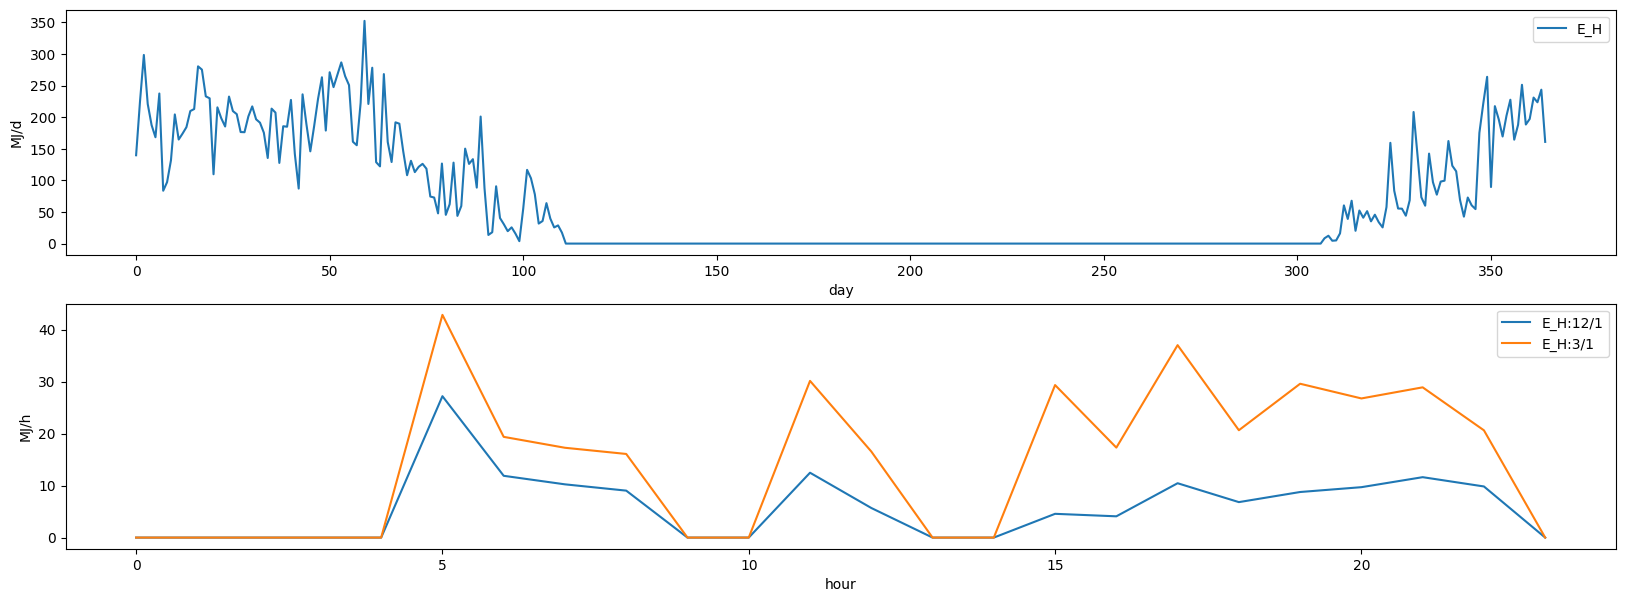

In [8]:
get_each_graph(E_H_d_t_2)

### 計算条件3

- 主たる居室の暖房設備を温水床暖房、敷設率40％、上面放熱率95％に変更
- その他居室の暖房設備を温水床暖房、敷設率30％、上面放熱率92％に変更

In [9]:
house_base, house_ENV, H_MR, H_OR, H_HS = get_default_hot_water_heating()
H_MR = {'type': '温水暖房用床暖房', 'r_Af': 0.4, 'r_up': 0.95}
H_OR = {'type': '温水暖房用床暖房', 'r_Af': 0.3, 'r_up': 0.92}

E_H_d_t_3 = calc_results(house_base, house_ENV, H_MR, H_OR, H_HS)

ガス従来型温水暖房機 E_G_hs = 38766.00708305742 [MJ] (L_T_H_rad = 24115.632682185947 [MJ])
ガス従来型温水暖房機 E_E_hs = 261.0140059025478 [kwh]
温水暖房用床暖房 E_E_rad_d_t_1 = 0.0 [KWh] (L_T_H_rad_d_t_1 = 12233.887997985712 [MJ])
温水暖房用床暖房 E_E_rad_d_t_3 = 0.0 [KWh] (L_T_H_rad_d_t_3 = 4618.426655912248 [MJ])
温水暖房用床暖房 E_E_rad_d_t_4 = 0.0 [KWh] (L_T_H_rad_d_t_4 = 3209.3356422404863 [MJ])
温水暖房用床暖房 E_E_rad_d_t_5 = 0.0 [KWh] (L_T_H_rad_d_t_5 = 4053.982386047498 [MJ])
ガス従来型温水暖房機 E_G_hs = 38766.00708305742 [MJ] (L_T_H_rad = 24115.632682185947 [MJ])
ガス従来型温水暖房機 E_K_hs = 0.0 [MJ] (L_T_H_rad = 24115.632682185947 [MJ])
温水暖房用床暖房 Q_UT_H_d_t_1 = 527.2104099553012 [MJ]
温水暖房用床暖房 Q_UT_H_d_t_2 = 0.0 [MJ]
温水暖房用床暖房 Q_UT_H_d_t_3 = 195.37534023098488 [MJ]
温水暖房用床暖房 Q_UT_H_d_t_4 = 96.59043523198571 [MJ]
温水暖房用床暖房 Q_UT_H_d_t_5 = 351.1030227993083 [MJ]
Q_UT_hs = 0.0 [MJ]
E_H=43150.84213756789MJ/a


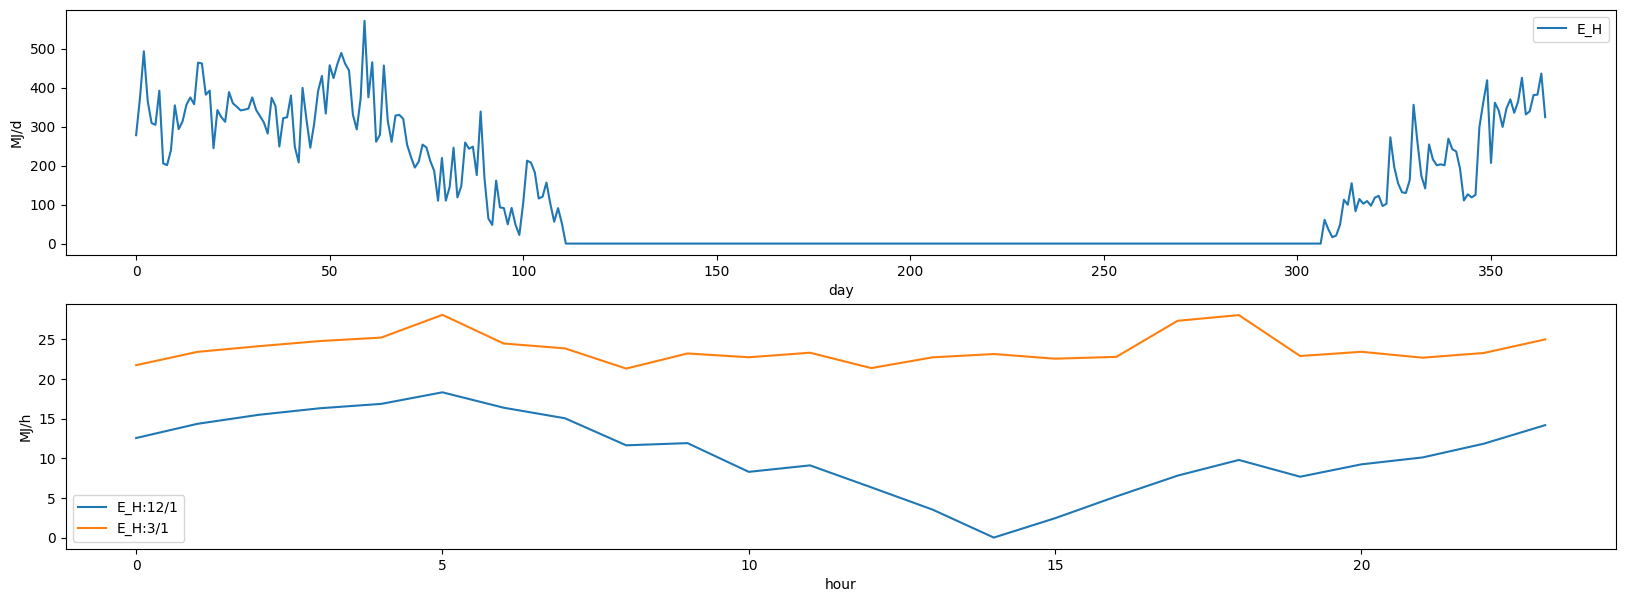

In [10]:
get_each_graph(E_H_d_t_3)

### 計算条件4

- 主たる居室の暖房設備を温水床暖房、敷設率40％、仮想床の床面積を除いた敷設率50％、上面放熱率95％に変更
- その他の居室の暖房設備を温水床暖房、敷設率30％、上面放熱率92％に変更

In [11]:
house_base, house_ENV, H_MR, H_OR, H_HS = get_default_hot_water_heating()
H_MR = {'type': '温水暖房用床暖房', 'r_Af': 0.4, 'r_dash_Af': 0.5, 'r_up': 0.95}
H_OR = {'type': '温水暖房用床暖房', 'r_Af': 0.3, 'r_up': 0.92}

E_H_d_t_4 = calc_results(house_base, house_ENV, H_MR, H_OR, H_HS)

ガス従来型温水暖房機 E_G_hs = 38596.564781022425 [MJ] (L_T_H_rad = 23938.311199354375 [MJ])
ガス従来型温水暖房機 E_E_hs = 260.87280398418534 [kwh]
温水暖房用床暖房 E_E_rad_d_t_1 = 0.0 [KWh] (L_T_H_rad_d_t_1 = 12056.56651515414 [MJ])
温水暖房用床暖房 E_E_rad_d_t_3 = 0.0 [KWh] (L_T_H_rad_d_t_3 = 4618.426655912248 [MJ])
温水暖房用床暖房 E_E_rad_d_t_4 = 0.0 [KWh] (L_T_H_rad_d_t_4 = 3209.3356422404863 [MJ])
温水暖房用床暖房 E_E_rad_d_t_5 = 0.0 [KWh] (L_T_H_rad_d_t_5 = 4053.982386047498 [MJ])
ガス従来型温水暖房機 E_G_hs = 38596.564781022425 [MJ] (L_T_H_rad = 23938.311199354375 [MJ])
ガス従来型温水暖房機 E_K_hs = 0.0 [MJ] (L_T_H_rad = 23938.311199354375 [MJ])
温水暖房用床暖房 Q_UT_H_d_t_1 = 473.0916798075254 [MJ]
温水暖房用床暖房 Q_UT_H_d_t_2 = 0.0 [MJ]
温水暖房用床暖房 Q_UT_H_d_t_3 = 195.37534023098488 [MJ]
温水暖房用床暖房 Q_UT_H_d_t_4 = 96.59043523198571 [MJ]
温水暖房用床暖房 Q_UT_H_d_t_5 = 351.1030227993083 [MJ]
Q_UT_hs = 0.0 [MJ]
E_H=42895.055298477666MJ/a


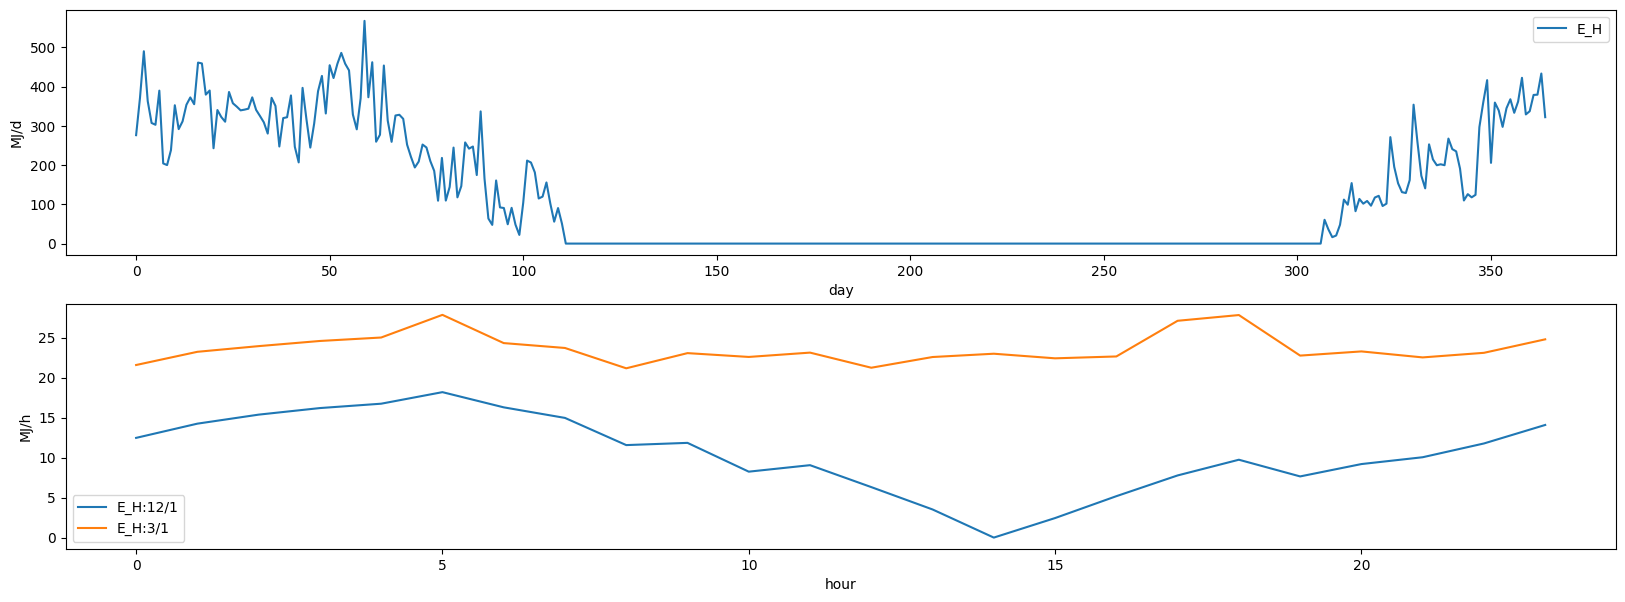

In [12]:
get_each_graph(E_H_d_t_4)

### 計算条件5

- 主たる居室の暖房設備を温水床暖房、敷設率40％、上面放熱率を95％に変更
- その他居室の暖房設備をルームエアコンに変更

In [13]:
house_base, house_ENV, H_MR, H_OR, H_HS = get_default_hot_water_heating()
H_MR = {'type': '温水暖房用床暖房', 'r_Af': 0.4, 'r_up': 0.95}
H_OR = {'type': 'ルームエアコンディショナー', 'e_class': 'ろ', 'dualcompressor': False}

E_H_d_t_5 = calc_results(house_base, house_ENV, H_MR, H_OR, H_HS)

ガス従来型温水暖房機 E_G_hs = 12361.464254153758 [MJ] (L_T_H_rad = 13616.80729172584 [MJ])
ガス従来型温水暖房機 E_E_hs = 89.86676106020093 [kwh]
温水暖房用床暖房 E_E_rad_d_t_1 = 0.0 [KWh] (L_T_H_rad_d_t_1 = 10377.951055964073 [MJ])
ガス従来型温水暖房機 E_G_hs = 12361.464254153758 [MJ] (L_T_H_rad = 13616.80729172584 [MJ])
ガス従来型温水暖房機 E_K_hs = 0.0 [MJ] (L_T_H_rad = 13616.80729172584 [MJ])
温水暖房用床暖房 Q_UT_H_d_t_1 = 2798.4321286578643 [MJ]
ルームエアコンディショナー Q_UT_H_d_t_2 = 0.0 [MJ]
ルームエアコンディショナー Q_UT_H_d_t_3 = 0.0 [MJ]
ルームエアコンディショナー Q_UT_H_d_t_4 = 4.064692296222255 [MJ]
ルームエアコンディショナー Q_UT_H_d_t_5 = 2.2237294931230913 [MJ]
Q_UT_hs = 0.0 [MJ]
ルームエアコンディショナー Q_UT_H_d_t_2 = 0.0 [MJ]
ルームエアコンディショナー Q_UT_H_d_t_3 = 0.0 [MJ]
ルームエアコンディショナー Q_UT_H_d_t_4 = 4.064692296222255 [MJ]
ルームエアコンディショナー Q_UT_H_d_t_5 = 2.2237294931230913 [MJ]
E_H=15925.058685612865MJ/a


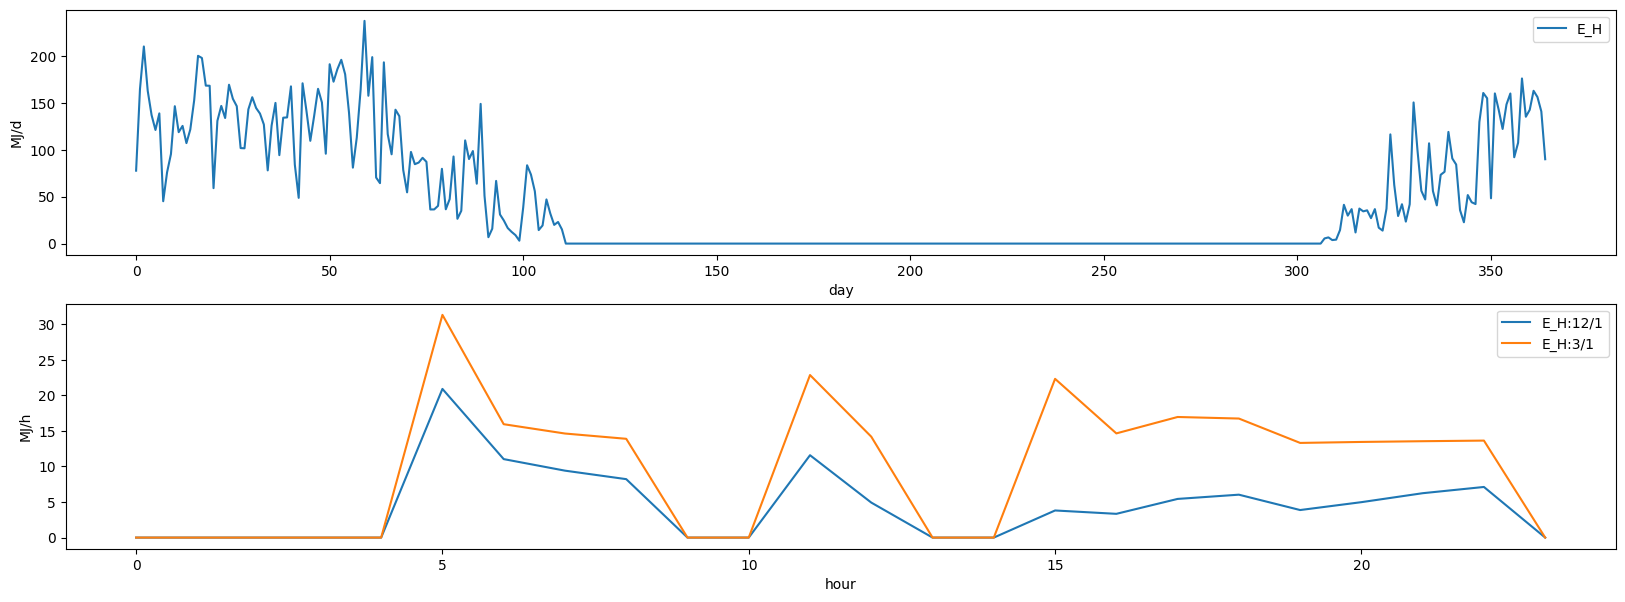

In [14]:
get_each_graph(E_H_d_t_5)

### 計算条件6

- 温水暖房の熱源機をガス潜熱回収型温水暖房機、効率87％に変更

In [15]:
house_base, house_ENV, H_MR, H_OR, H_HS = get_default_hot_water_heating()
H_HS['type'] = 'ガス潜熱回収型温水暖房機'
H_HS['e_rtd_hs'] = 0.87

E_H_d_t_6 = calc_results(house_base, house_ENV, H_MR, H_OR, H_HS)

ガス潜熱回収型温水暖房機 E_G_hs = 33941.61605673183 [MJ] (L_T_H_rad = 26169.07775262852 [MJ])
ガス潜熱回収型温水暖房機 E_E_hs = 256.9936800472765 [kwh]
温水暖房用パネルラジエーター E_E_rad_d_t_1 = 0.0 [KWh] (L_T_H_rad_d_t_1 = 13369.716326035541 [MJ])
温水暖房用パネルラジエーター E_E_rad_d_t_3 = 0.0 [KWh] (L_T_H_rad_d_t_3 = 4975.1037042428225 [MJ])
温水暖房用パネルラジエーター E_E_rad_d_t_4 = 0.0 [KWh] (L_T_H_rad_d_t_4 = 3457.1898249005208 [MJ])
温水暖房用パネルラジエーター E_E_rad_d_t_5 = 0.0 [KWh] (L_T_H_rad_d_t_5 = 4367.067897449638 [MJ])
ガス潜熱回収型温水暖房機 E_G_hs = 33941.61605673183 [MJ] (L_T_H_rad = 26169.07775262852 [MJ])
ガス潜熱回収型温水暖房機 E_K_hs = 0.0 [MJ] (L_T_H_rad = 26169.07775262852 [MJ])
温水暖房用パネルラジエーター Q_UT_H_d_t_1 = 0.4193211985240808 [MJ]
温水暖房用パネルラジエーター Q_UT_H_d_t_2 = 0.0 [MJ]
温水暖房用パネルラジエーター Q_UT_H_d_t_3 = 0.0 [MJ]
温水暖房用パネルラジエーター Q_UT_H_d_t_4 = 0.0 [MJ]
温水暖房用パネルラジエーター Q_UT_H_d_t_5 = 0.3157451815366752 [MJ]
Q_UT_hs = 50.315705897968186 [MJ]
E_H=36451.02842820994MJ/a


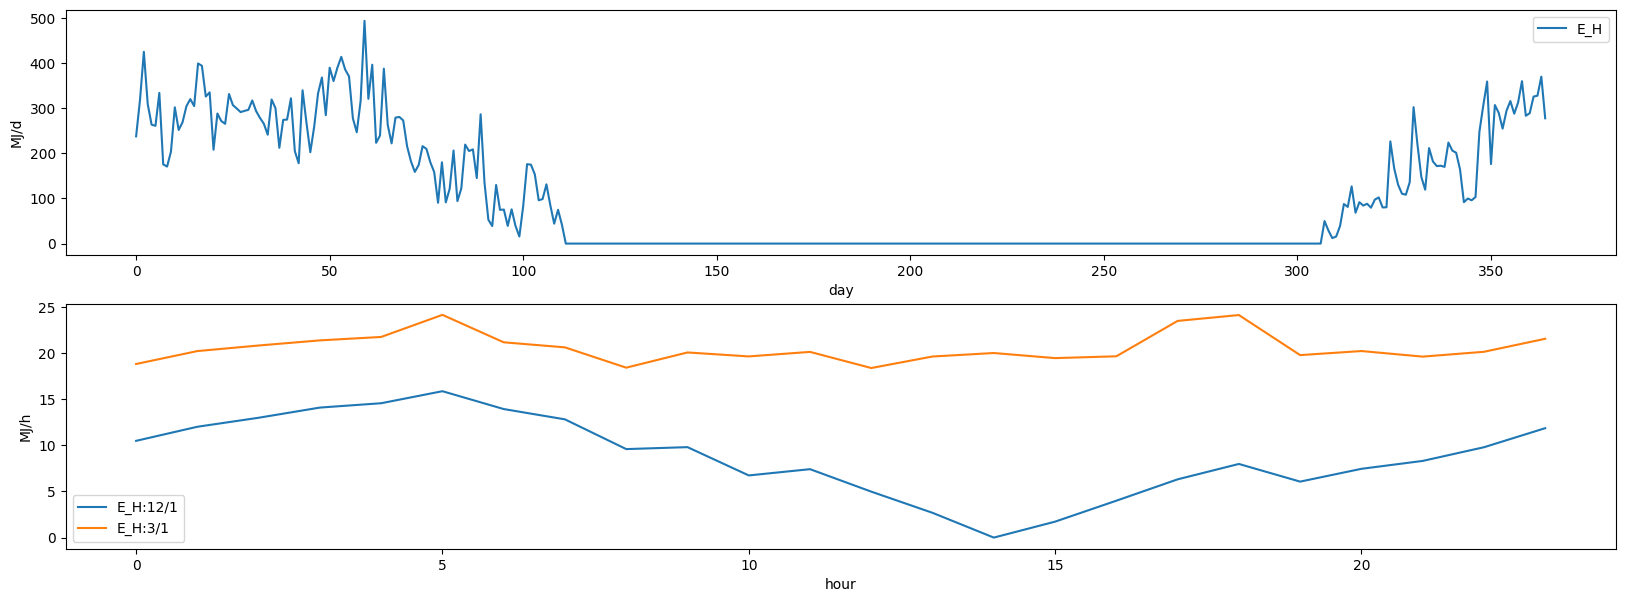

In [16]:
get_each_graph(E_H_d_t_6)

### 計算条件7

- 温水暖房の熱源機を石油従来型温水暖房機、効率82％に変更

In [17]:
house_base, house_ENV, H_MR, H_OR, H_HS = get_default_hot_water_heating()
H_HS['type'] = '石油従来型温水暖房機'
H_HS['e_rtd_hs'] = 0.82

E_H_d_t_7 = calc_results(house_base, house_ENV, H_MR, H_OR, H_HS)

石油従来型温水暖房機 E_K_hs = 40397.171466752145 [MJ] (L_T_H_rad = 26169.07775262852 [MJ])
石油従来型温水暖房機 E_E_hs = 315.63430955562677 [kwh]
温水暖房用パネルラジエーター E_E_rad_d_t_1 = 0.0 [KWh] (L_T_H_rad_d_t_1 = 13369.716326035541 [MJ])
温水暖房用パネルラジエーター E_E_rad_d_t_3 = 0.0 [KWh] (L_T_H_rad_d_t_3 = 4975.1037042428225 [MJ])
温水暖房用パネルラジエーター E_E_rad_d_t_4 = 0.0 [KWh] (L_T_H_rad_d_t_4 = 3457.1898249005208 [MJ])
温水暖房用パネルラジエーター E_E_rad_d_t_5 = 0.0 [KWh] (L_T_H_rad_d_t_5 = 4367.067897449638 [MJ])
石油従来型温水暖房機 E_G_hs = 0.0 [MJ] (L_T_H_rad = 26169.07775262852 [MJ])
石油従来型温水暖房機 E_K_hs = 40397.171466752145 [MJ] (L_T_H_rad = 26169.07775262852 [MJ])
温水暖房用パネルラジエーター Q_UT_H_d_t_1 = 0.4193211985240808 [MJ]
温水暖房用パネルラジエーター Q_UT_H_d_t_2 = 0.0 [MJ]
温水暖房用パネルラジエーター Q_UT_H_d_t_3 = 0.0 [MJ]
温水暖房用パネルラジエーター Q_UT_H_d_t_4 = 0.0 [MJ]
温水暖房用パネルラジエーター Q_UT_H_d_t_5 = 0.3157451815366752 [MJ]
Q_UT_hs = 50.315705897968186 [MJ]
E_H=43478.91638223176MJ/a


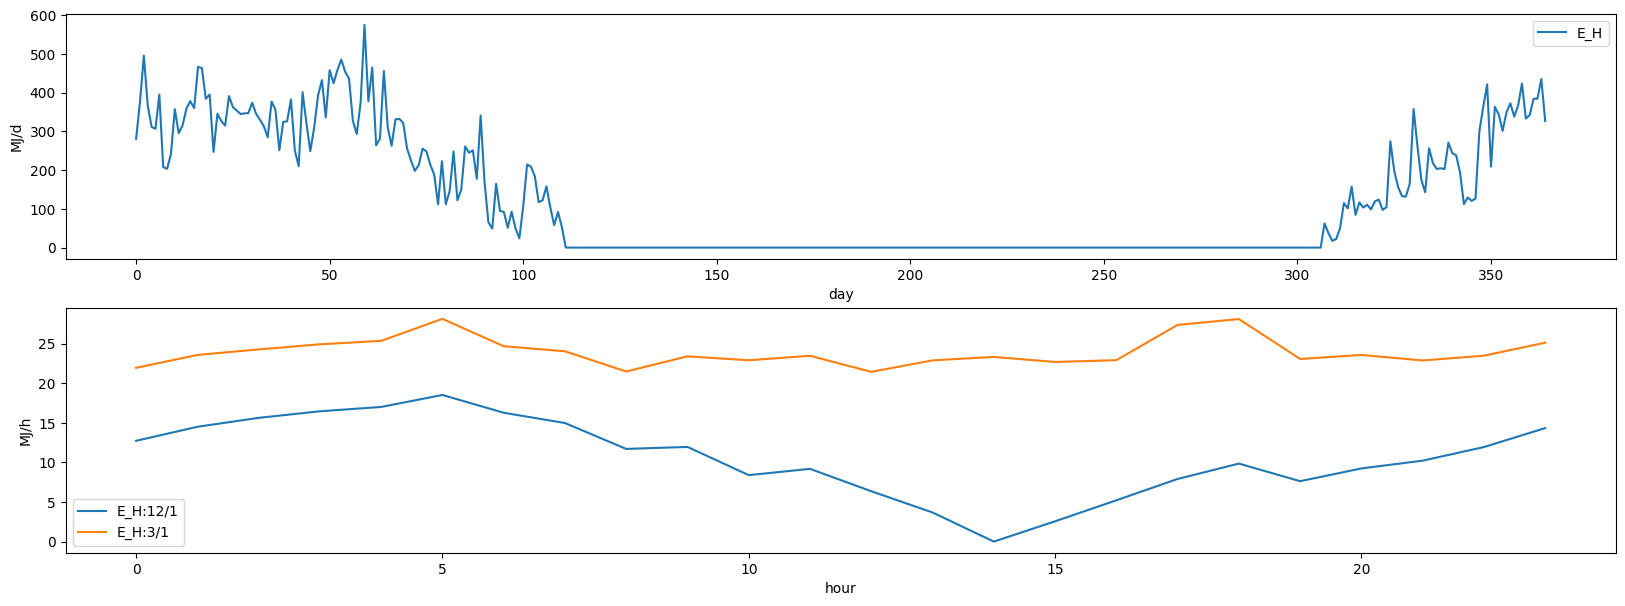

In [18]:
get_each_graph(E_H_d_t_7)

### 計算条件8

- 温水暖房の熱源機を石油潜熱回収型温水暖房機

In [19]:
house_base, house_ENV, H_MR, H_OR, H_HS = get_default_hot_water_heating()
H_HS['type'] = '石油潜熱回収型温水暖房機'
del H_HS['e_rtd_hs']
E_H_d_t_8 = calc_results(house_base, house_ENV, H_MR, H_OR, H_HS)

石油潜熱回収型温水暖房機 E_K_hs = 33486.91152893065 [MJ] (L_T_H_rad = 26169.07775262852 [MJ])
石油潜熱回収型温水暖房機 E_E_hs = 247.21575960744224 [kwh]
温水暖房用パネルラジエーター E_E_rad_d_t_1 = 0.0 [KWh] (L_T_H_rad_d_t_1 = 13369.716326035541 [MJ])
温水暖房用パネルラジエーター E_E_rad_d_t_3 = 0.0 [KWh] (L_T_H_rad_d_t_3 = 4975.1037042428225 [MJ])
温水暖房用パネルラジエーター E_E_rad_d_t_4 = 0.0 [KWh] (L_T_H_rad_d_t_4 = 3457.1898249005208 [MJ])
温水暖房用パネルラジエーター E_E_rad_d_t_5 = 0.0 [KWh] (L_T_H_rad_d_t_5 = 4367.067897449638 [MJ])
石油潜熱回収型温水暖房機 E_G_hs = 0.0 [MJ] (L_T_H_rad = 26169.07775262852 [MJ])
石油潜熱回収型温水暖房機 E_K_hs = 33486.91152893065 [MJ] (L_T_H_rad = 26169.07775262852 [MJ])
温水暖房用パネルラジエーター Q_UT_H_d_t_1 = 0.4193211985240808 [MJ]
温水暖房用パネルラジエーター Q_UT_H_d_t_2 = 0.0 [MJ]
温水暖房用パネルラジエーター Q_UT_H_d_t_3 = 0.0 [MJ]
温水暖房用パネルラジエーター Q_UT_H_d_t_4 = 0.0 [MJ]
温水暖房用パネルラジエーター Q_UT_H_d_t_5 = 0.3157451815366752 [MJ]
Q_UT_hs = 50.315705897968186 [MJ]
E_H=35900.89139691598MJ/a


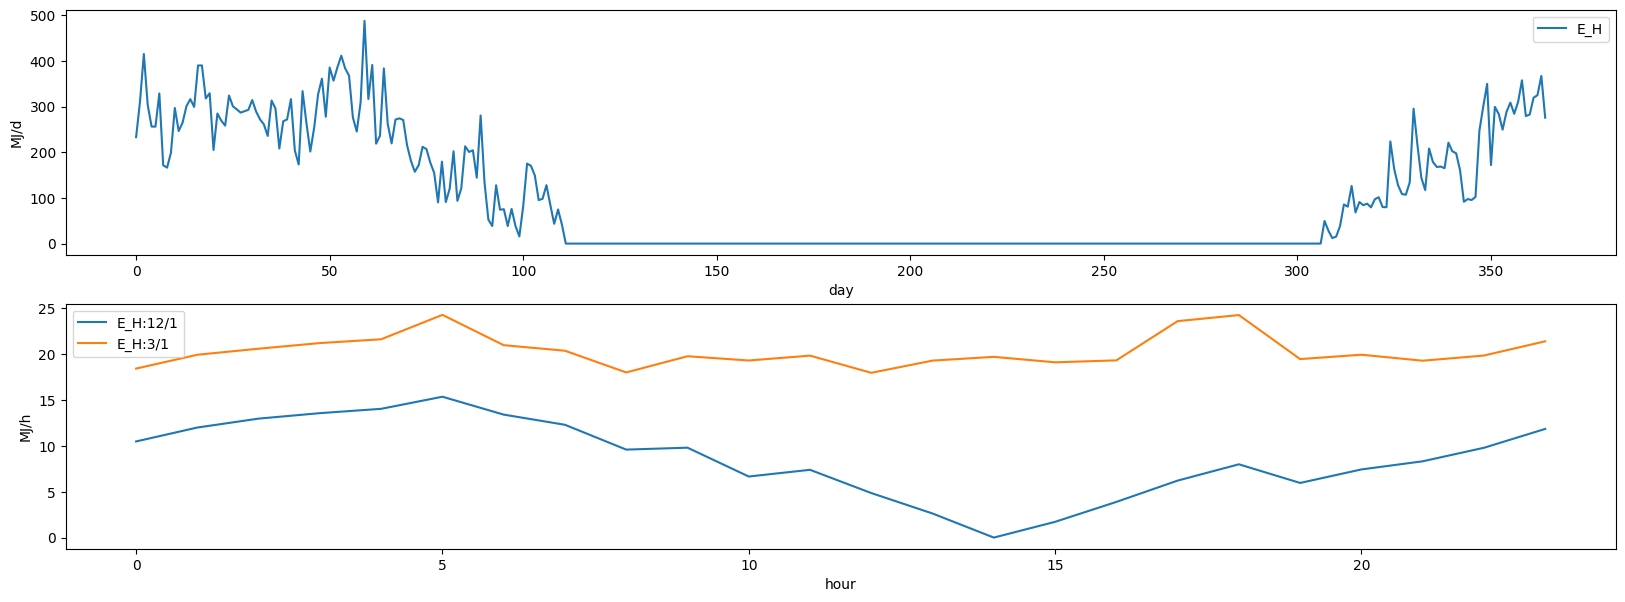

In [20]:
get_each_graph(E_H_d_t_8)

### 計算条件9

- 温水暖房の熱源機を電気ヒートポンプ温水暖房機（フロン系冷媒）に変更

In [21]:
house_base, house_ENV, H_MR, H_OR, H_HS = get_default_hot_water_heating()
H_HS['type'] = '電気ヒートポンプ温水暖房機'

E_H_d_t_9 = calc_results(house_base, house_ENV, H_MR, H_OR, H_HS)

電気ヒートポンプ温水暖房機 E_E_hs = 2928.448243632172 [kwh]
温水暖房用パネルラジエーター E_E_rad_d_t_1 = 0.0 [KWh] (L_T_H_rad_d_t_1 = 13369.716326035541 [MJ])
温水暖房用パネルラジエーター E_E_rad_d_t_3 = 0.0 [KWh] (L_T_H_rad_d_t_3 = 4975.1037042428225 [MJ])
温水暖房用パネルラジエーター E_E_rad_d_t_4 = 0.0 [KWh] (L_T_H_rad_d_t_4 = 3457.1898249005208 [MJ])
温水暖房用パネルラジエーター E_E_rad_d_t_5 = 0.0 [KWh] (L_T_H_rad_d_t_5 = 4367.067897449638 [MJ])
電気ヒートポンプ温水暖房機 E_G_hs = 0.0 [MJ] (L_T_H_rad = 26169.07775262852 [MJ])
電気ヒートポンプ温水暖房機 E_K_hs = 0.0 [MJ] (L_T_H_rad = 26169.07775262852 [MJ])
温水暖房用パネルラジエーター Q_UT_H_d_t_1 = 14.609730375649383 [MJ]
温水暖房用パネルラジエーター Q_UT_H_d_t_2 = 0.0 [MJ]
温水暖房用パネルラジエーター Q_UT_H_d_t_3 = 1.2622580096035918 [MJ]
温水暖房用パネルラジエーター Q_UT_H_d_t_4 = 0.0 [MJ]
温水暖房用パネルラジエーター Q_UT_H_d_t_5 = 18.783280537790827 [MJ]
Q_UT_hs = 1981.0938234575437 [MJ]
E_H=28636.063630059172MJ/a


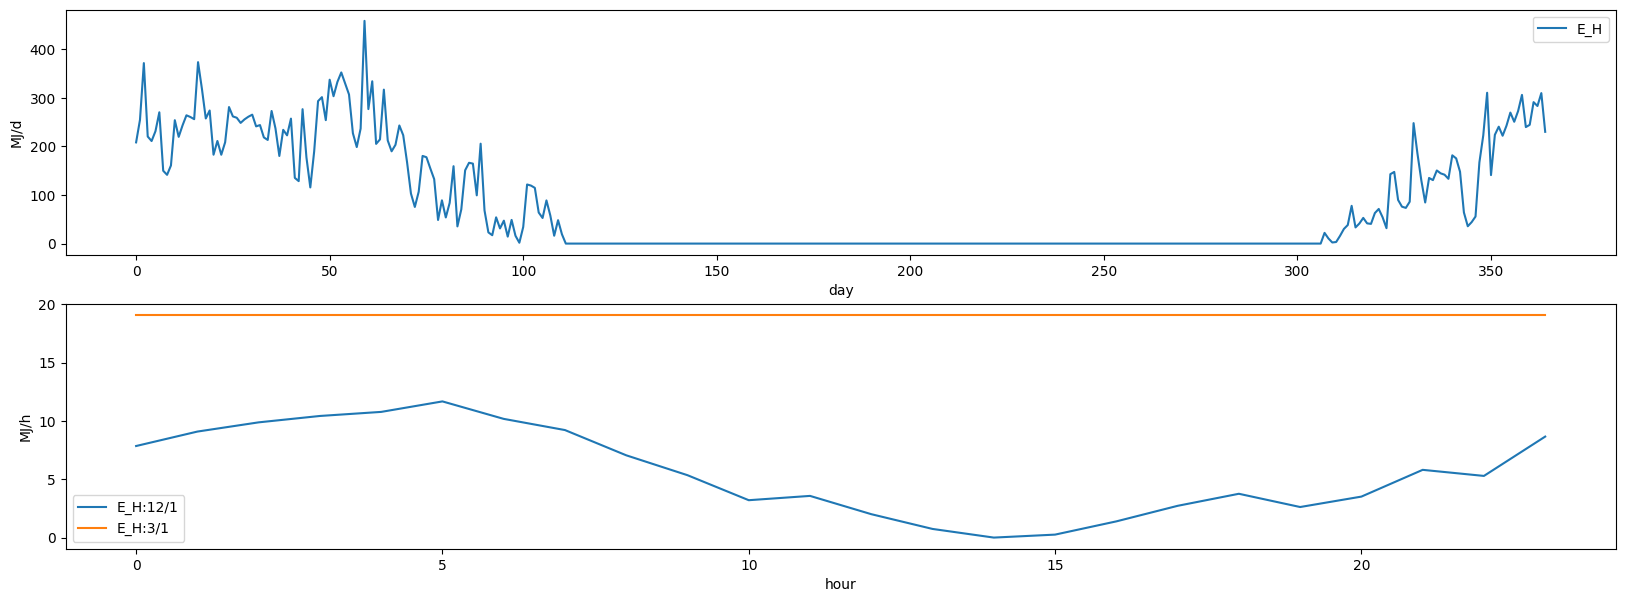

In [22]:
get_each_graph(E_H_d_t_9)

### 計算条件10

- 温水暖房の熱源機を電気ヒーター温水暖房機に変更

In [23]:
house_base, house_ENV, H_MR, H_OR, H_HS = get_default_hot_water_heating()
H_HS['type'] = '電気ヒーター温水暖房機'

E_H_d_t_10 = calc_results(house_base, house_ENV, H_MR, H_OR, H_HS)

電気ヒーター温水暖房機 E_E_hs = 8596.217777036554 [kwh]
温水暖房用パネルラジエーター E_E_rad_d_t_1 = 0.0 [KWh] (L_T_H_rad_d_t_1 = 13369.716326035541 [MJ])
温水暖房用パネルラジエーター E_E_rad_d_t_3 = 0.0 [KWh] (L_T_H_rad_d_t_3 = 4975.1037042428225 [MJ])
温水暖房用パネルラジエーター E_E_rad_d_t_4 = 0.0 [KWh] (L_T_H_rad_d_t_4 = 3457.1898249005208 [MJ])
温水暖房用パネルラジエーター E_E_rad_d_t_5 = 0.0 [KWh] (L_T_H_rad_d_t_5 = 4367.067897449638 [MJ])
電気ヒーター温水暖房機 E_G_hs = 0.0 [MJ] (L_T_H_rad = 26169.07775262852 [MJ])
電気ヒーター温水暖房機 E_K_hs = 0.0 [MJ] (L_T_H_rad = 26169.07775262852 [MJ])
温水暖房用パネルラジエーター Q_UT_H_d_t_1 = 0.4193211985240808 [MJ]
温水暖房用パネルラジエーター Q_UT_H_d_t_2 = 0.0 [MJ]
温水暖房用パネルラジエーター Q_UT_H_d_t_3 = 0.0 [MJ]
温水暖房用パネルラジエーター Q_UT_H_d_t_4 = 0.0 [MJ]
温水暖房用パネルラジエーター Q_UT_H_d_t_5 = 0.3157451815366752 [MJ]
Q_UT_hs = 50.315705897968186 [MJ]
E_H=83900.23955809345MJ/a


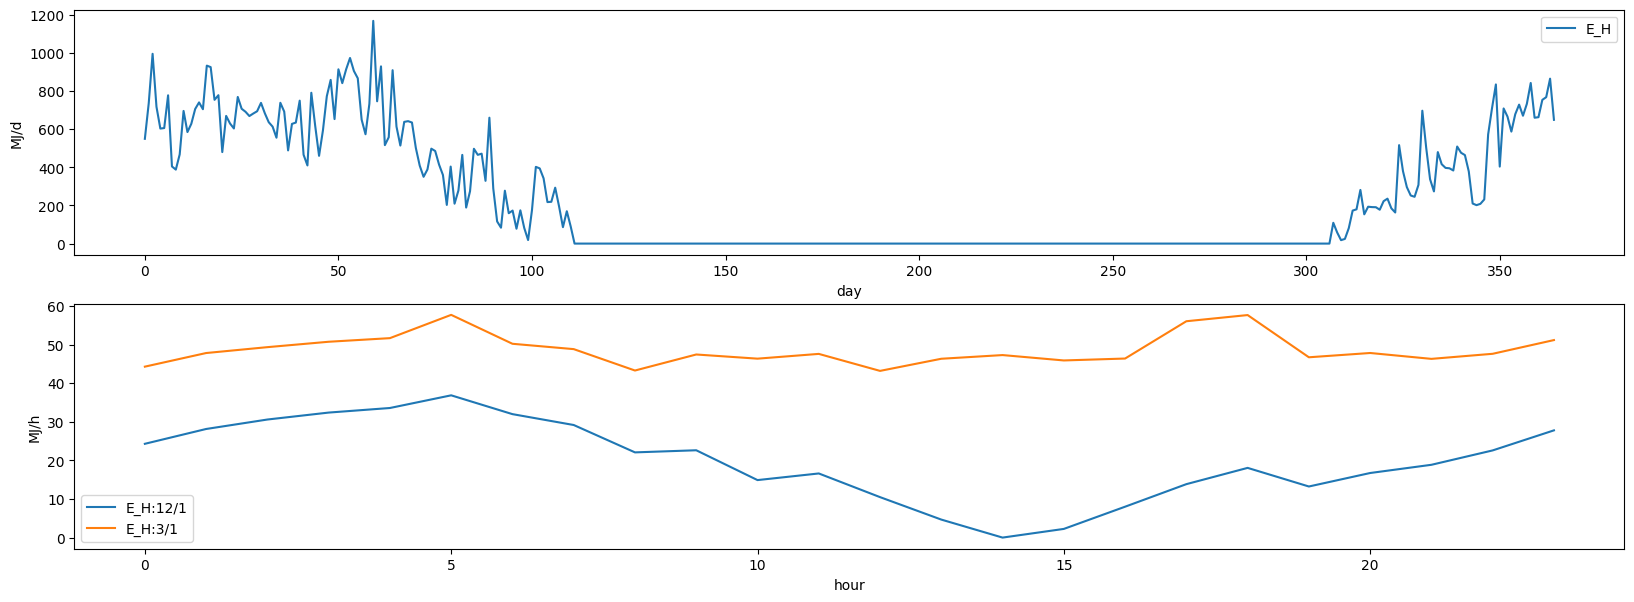

In [24]:
get_each_graph(E_H_d_t_10)

### 計算条件11

- 温水暖房の熱源機を地中熱ヒートポンプ温水暖房機、熱交換機タイプ5に変更

In [25]:
house_base, house_ENV, H_MR, H_OR, H_HS = get_default_hot_water_heating()
H_HS['type'] = '地中熱ヒートポンプ温水暖房機'
H_HS['HeatExchanger'] = '5'

E_H_d_t_11 = calc_results(house_base, house_ENV, H_MR, H_OR, H_HS)

地中熱ヒートポンプ温水暖房機 E_E_hs = 3054.6550140794743 [kwh]
温水暖房用パネルラジエーター E_E_rad_d_t_1 = 0.0 [KWh] (L_T_H_rad_d_t_1 = 13369.716326035541 [MJ])
温水暖房用パネルラジエーター E_E_rad_d_t_3 = 0.0 [KWh] (L_T_H_rad_d_t_3 = 4975.1037042428225 [MJ])
温水暖房用パネルラジエーター E_E_rad_d_t_4 = 0.0 [KWh] (L_T_H_rad_d_t_4 = 3457.1898249005208 [MJ])
温水暖房用パネルラジエーター E_E_rad_d_t_5 = 0.0 [KWh] (L_T_H_rad_d_t_5 = 4367.067897449638 [MJ])
地中熱ヒートポンプ温水暖房機 E_G_hs = 0.0 [MJ] (L_T_H_rad = 26169.07775262852 [MJ])
地中熱ヒートポンプ温水暖房機 E_K_hs = 0.0 [MJ] (L_T_H_rad = 26169.07775262852 [MJ])
温水暖房用パネルラジエーター Q_UT_H_d_t_1 = 14.609730375649383 [MJ]
温水暖房用パネルラジエーター Q_UT_H_d_t_2 = 0.0 [MJ]
温水暖房用パネルラジエーター Q_UT_H_d_t_3 = 1.2622580096035918 [MJ]
温水暖房用パネルラジエーター Q_UT_H_d_t_4 = 0.0 [MJ]
温水暖房用パネルラジエーター Q_UT_H_d_t_5 = 18.783280537790827 [MJ]
Q_UT_hs = 27.842984174256806 [MJ]
E_H=29867.841709624845MJ/a


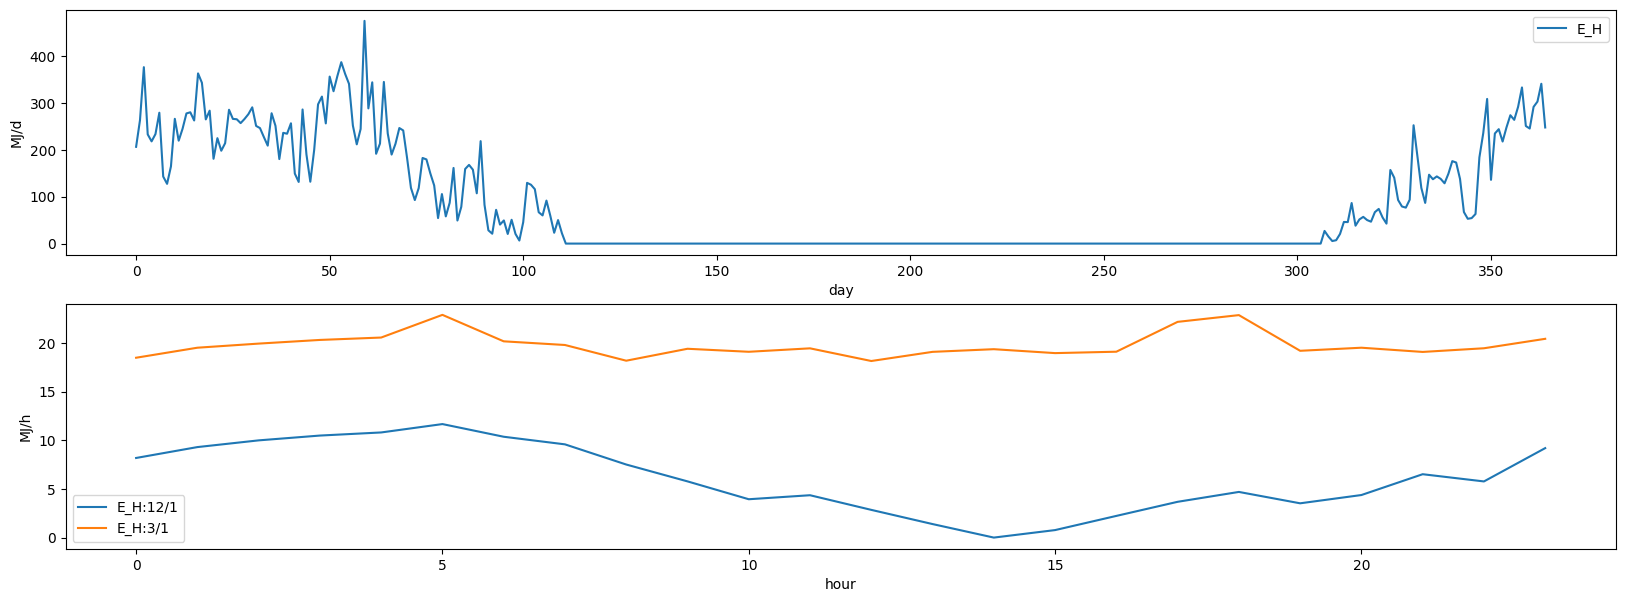

In [26]:
get_each_graph(E_H_d_t_11)

### 計算条件12

- 主たる居室の暖房設備を温水床暖房（併用運転に対応）、敷設率40％、上面放熱率95％に変更
- その他居室の暖房設備をルームエアコンに変更
- 温水暖房の熱源機をガス潜熱回収型温水暖房機、効率87％に変更

In [27]:
house_base, house_ENV, H_MR, H_OR, H_HS = get_default_hot_water_heating()
H_MR = {'type': '温水床暖房（併用運転に対応）', 'r_Af': 0.4, 'r_up': 0.95}
H_OR = {'type': 'ルームエアコンディショナー', 'e_class': 'ろ', 'dualcompressor': False}
H_HS['type'] = 'ガス潜熱回収型温水暖房機'
H_HS['e_rtd_hs'] = 0.87

E_H_d_t_12 = calc_results(house_base, house_ENV, H_MR, H_OR, H_HS)

ガス潜熱回収型温水暖房機 E_G_hs = 4103.136432240549 [MJ] (L_T_H_rad = 13616.80729172584 [MJ])
ガス潜熱回収型温水暖房機 E_E_hs = 59.69484759628255 [kwh]
温水床暖房（併用運転に対応） E_E_rad_d_t_1 = 0.0 [KWh] (L_T_H_rad_d_t_1 = 10377.951055964073 [MJ])
ガス潜熱回収型温水暖房機 E_G_hs = 4103.136432240549 [MJ] (L_T_H_rad = 13616.80729172584 [MJ])
ガス潜熱回収型温水暖房機 E_K_hs = 0.0 [MJ] (L_T_H_rad = 13616.80729172584 [MJ])
温水床暖房（併用運転に対応） Q_UT_H_d_t_1 = 7697.508477037511 [MJ]
ルームエアコンディショナー Q_UT_H_d_t_2 = 0.0 [MJ]
ルームエアコンディショナー Q_UT_H_d_t_3 = 0.0 [MJ]
ルームエアコンディショナー Q_UT_H_d_t_4 = 4.064692296222255 [MJ]
ルームエアコンディショナー Q_UT_H_d_t_5 = 2.2237294931230913 [MJ]
Q_UT_hs = 0.0 [MJ]
ルームエアコンディショナー Q_UT_H_d_t_2 = 0.0 [MJ]
ルームエアコンディショナー Q_UT_H_d_t_3 = 0.0 [MJ]
ルームエアコンディショナー Q_UT_H_d_t_4 = 4.064692296222255 [MJ]
ルームエアコンディショナー Q_UT_H_d_t_5 = 2.2237294931230913 [MJ]
E_H=12075.366282736275MJ/a


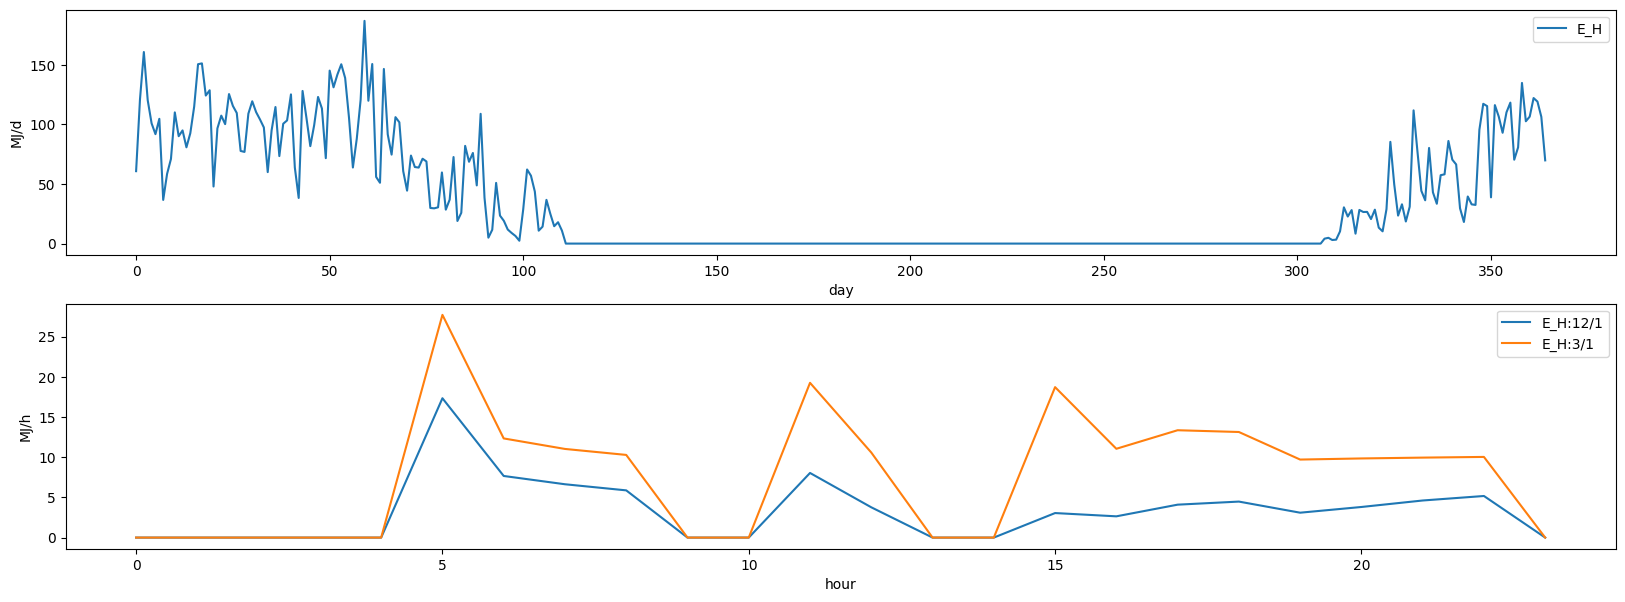

In [28]:
get_each_graph(E_H_d_t_12)

### 計算条件13

- 主たる居室の暖房設備を温水床暖房（併用運転に対応）、敷設率40％、上面放熱率95％に変更
- 温水暖房の熱源機をガス潜熱回収型温水暖房機、効率87％に変更

In [29]:
house_base, house_ENV, H_MR, H_OR, H_HS = get_default_hot_water_heating()
H_MR = {'type': '温水床暖房（併用運転に対応）', 'r_Af': 0.4, 'r_up': 0.95}
H_HS['type'] = 'ガス潜熱回収型温水暖房機'
H_HS['e_rtd_hs'] = 0.87

E_H_d_t_13 = calc_results(house_base, house_ENV, H_MR, H_OR, H_HS)

ガス潜熱回収型温水暖房機 E_G_hs = 20949.55500234244 [MJ] (L_T_H_rad = 25033.24942457869 [MJ])
ガス潜熱回収型温水暖房機 E_E_hs = 246.166962501952 [kwh]
温水床暖房（併用運転に対応） E_E_rad_d_t_1 = 0.0 [KWh] (L_T_H_rad_d_t_1 = 12233.887997985712 [MJ])
温水暖房用パネルラジエーター E_E_rad_d_t_3 = 0.0 [KWh] (L_T_H_rad_d_t_3 = 4975.1037042428225 [MJ])
温水暖房用パネルラジエーター E_E_rad_d_t_4 = 0.0 [KWh] (L_T_H_rad_d_t_4 = 3457.1898249005208 [MJ])
温水暖房用パネルラジエーター E_E_rad_d_t_5 = 0.0 [KWh] (L_T_H_rad_d_t_5 = 4367.067897449638 [MJ])
ガス潜熱回収型温水暖房機 E_G_hs = 20949.55500234244 [MJ] (L_T_H_rad = 25033.24942457869 [MJ])
ガス潜熱回収型温水暖房機 E_K_hs = 0.0 [MJ] (L_T_H_rad = 25033.24942457869 [MJ])
温水床暖房（併用運転に対応） Q_UT_H_d_t_1 = 7779.57179820171 [MJ]
温水暖房用パネルラジエーター Q_UT_H_d_t_2 = 0.0 [MJ]
温水暖房用パネルラジエーター Q_UT_H_d_t_3 = 612.8656854634125 [MJ]
温水暖房用パネルラジエーター Q_UT_H_d_t_4 = 341.6284243391477 [MJ]
温水暖房用パネルラジエーター Q_UT_H_d_t_5 = 789.6710896835662 [MJ]
Q_UT_hs = 0.0 [MJ]
E_H=38304.41164273139MJ/a


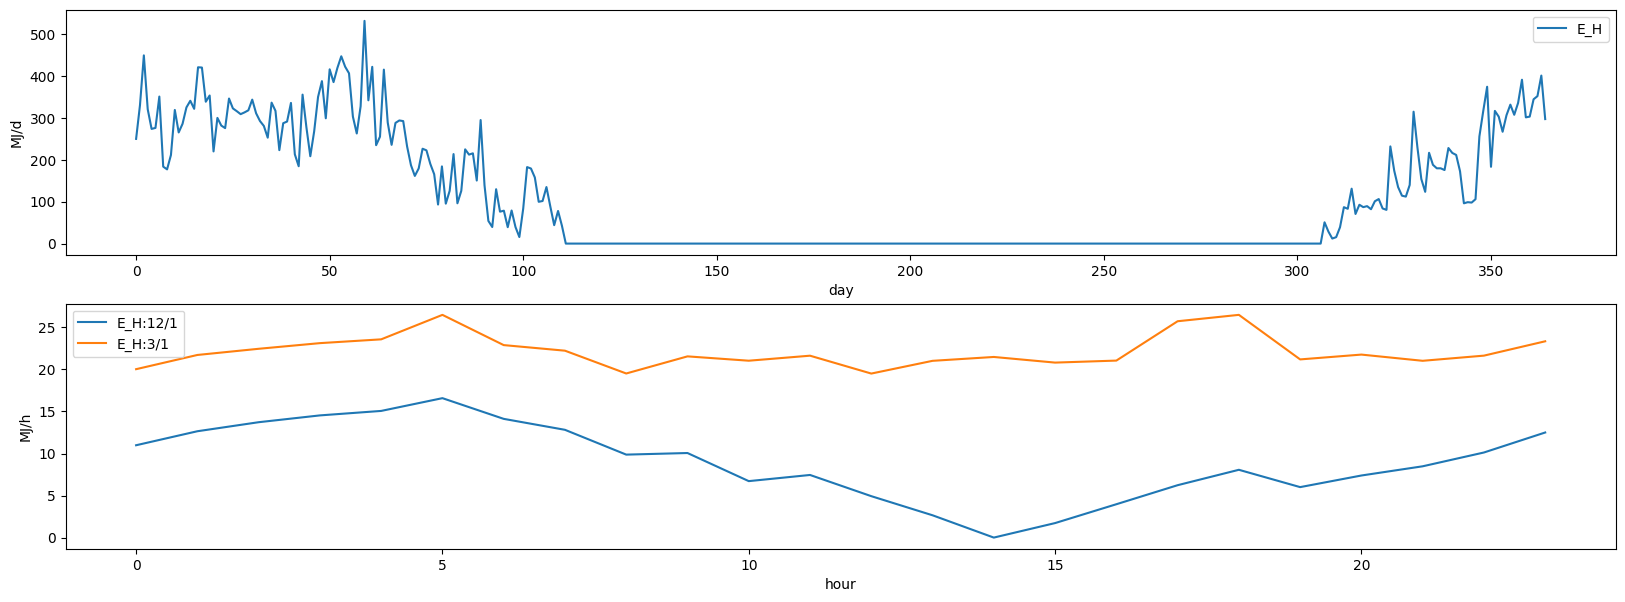

In [30]:
get_each_graph(E_H_d_t_13)

## 試算例の比較

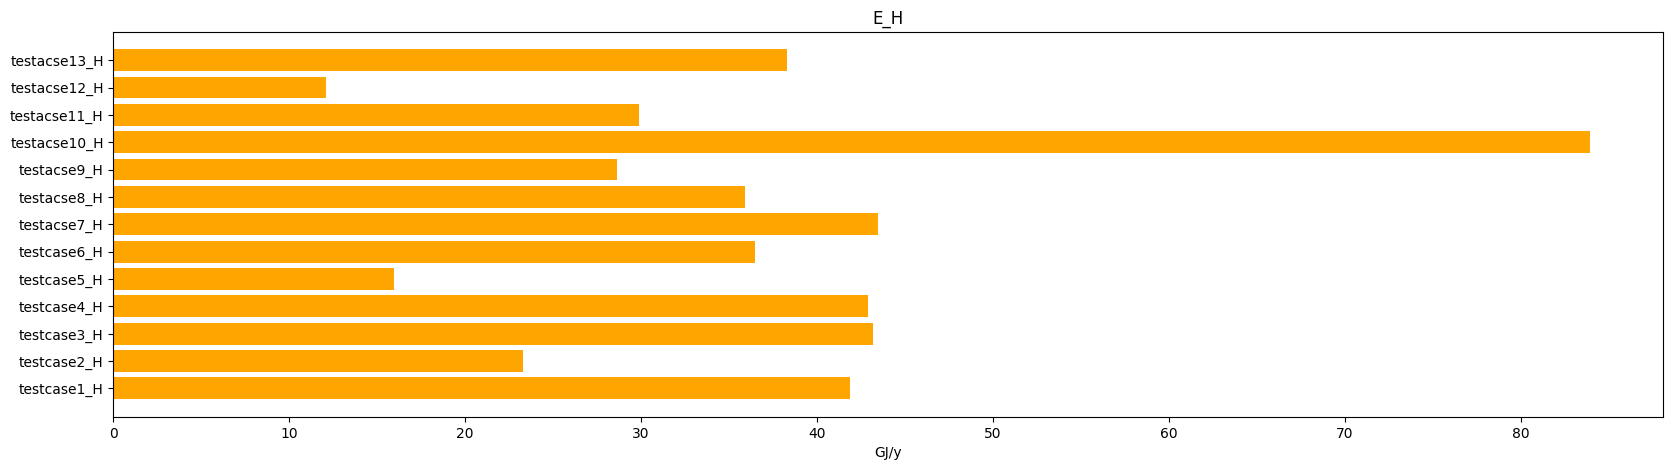

In [31]:
import matplotlib.pyplot as plt

dat_H = {"testcase1_H": np.sum(E_H_d_t_1)/1000, "testcase2_H": np.sum(E_H_d_t_2)/1000, "testcase3_H": np.sum(E_H_d_t_3)/1000, 
         "testcase4_H": np.sum(E_H_d_t_4)/1000, "testcase5_H": np.sum(E_H_d_t_5)/1000, "testcase6_H": np.sum(E_H_d_t_6)/1000,
         "testacse7_H": np.sum(E_H_d_t_7)/1000, "testacse8_H": np.sum(E_H_d_t_8)/1000, "testacse9_H": np.sum(E_H_d_t_9)/1000,
         "testacse10_H": np.sum(E_H_d_t_10)/1000, "testacse11_H": np.sum(E_H_d_t_11)/1000, "testacse12_H": np.sum(E_H_d_t_12)/1000,
         "testacse13_H": np.sum(E_H_d_t_13)/1000}

x_H = list(dat_H.keys())
y_H = list(dat_H.values())

fig = plt.figure(figsize=(20,5))

grh_H = fig.add_subplot(111)
grh_H.barh(x_H,y_H, color = "orange")
grh_H.set_xlabel("GJ/y")
grh_H.set_title("E_H")

plt.show()